# Airline Flight Delay Analysis and Prediction

As global interconnectivity develops and aviation activity rises to meet the growing demand, flight delays are becoming a chronic problem worldwide, causing significant impacts on the aviation industry and wider economy. Between 2002 and 2007, while the number of flights increased by 40.7%, the number of flights that arrived over 15 minutes late increased by 106.4% (Bureau of Transportation Statistics, 2009).

With reductions in flight delays, it is estimated that US net welfare could increase by $17.6Bn for a 10% reduction in delays, while a 30% reduction could yield $35.8Bn (Peterson et al., 2012). Furthermore, ICAO forecasts worldwide demand for air transport to continue increasing over the next 20 years, potentially necessitating the need to address flight delays.

In this project, lets explore the issue via a framework of questions as an introduction to airline on-time performance (OTP):

 1. When is the best time of day, day of the week, and time of year to fly to minimise delays? 
 2. Do older planes suffer more delays?
 3. How does the number of people flying between different locations change over time?
 4. Can you detect cascading failures as delays in one airport create delays in others?

Finally we will utilise available variables to construct a model that can accurately predict arrival delays.

#### Import required modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime
from scipy.stats import chisquare
import folium

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression

#### Load datasets for selected years
We will be using 2006 and 2007 as they have the highest flight volumes in the period from 1987 to 2008.
Note: 2008 has a lower flight volume due to the 2008 Global Financial Crisis.

Data source: ASA Statistical Computing Data Expo 2009: Airline on time data <br>
(https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/HG7NV7)

In [2]:
df2006 = pd.read_csv('2006.csv')
df2007 = pd.read_csv('2007.csv')

In [3]:
# Checking outline (shape) of dataframe - No. of rows & columns
print(f'2006: {df2006.shape}')
print(f'2007: {df2007.shape}')

2006: (7141922, 29)
2007: (7453215, 29)


In [4]:
# Merge both dataframes to prepare for combined analysis
merged_df = pd.concat([df2006, df2007], ignore_index=True)

In [5]:
merged_df.info() # Obtain latest overview of columns, datatypes and tail-end of CSV
merged_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14595137 entries, 0 to 14595136
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             int64  
 20  TaxiOut            int64  
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       int64  
 25  WeatherDelay    

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0         2006      1          11          3    743.0         745   1024.0   
1         2006      1          11          3   1053.0        1053   1313.0   
2         2006      1          11          3   1915.0        1915   2110.0   
3         2006      1          11          3   1753.0        1755   1925.0   
4         2006      1          11          3    824.0         832   1015.0   
...        ...    ...         ...        ...      ...         ...      ...   
14595132  2007     12          15          6   1558.0        1605   1749.0   
14595133  2007     12          15          6   1902.0        1851   2110.0   
14595134  2007     12          15          6   1024.0        1025   1750.0   
14595135  2007     12          15          6   1353.0        1315   1658.0   
14595136  2007     12          15          6   1824.0        1800   2001.0   

          CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0               1018            US        343  ...     45       13          0   
1               1318            US        613  ...     27       19          0   
2               2133            US        617  ...      4       11          0   
3               1933            US        300  ...     16       10          0   
4               1015            US        765  ...     27       12          0   
...              ...           ...        ...  ...    ...      ...        ...   
14595132        1736            DL         58  ...     14       17          0   
14595133        2105            DL         59  ...      6       21          0   
14595134        1735            DL         61  ...     14       19          0   
14595135        1622            DL         62  ...     11       14          0   
14595136        1928            DL         63  ...     10       26          0   

          CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0                      NaN         0             0            0        0   
1                      NaN         0             0            0        0   
2                      NaN         0             0            0        0   
3                      NaN         0             0            0        0   
4                      NaN         0             0            0        0   
...                    ...       ...           ...          ...      ...   
14595132               NaN         0             0            0        0   
14595133               NaN         0             0            0        0   
14595134               NaN         0             0            0       15   
14595135               NaN         0             0            0        0   
14595136               NaN         0            24            0        9   

          SecurityDelay  LateAircraftDelay  
0                     0                  0  
1                     0                  0  
2                     0                  0  
3                     0                  0  
4                     0                  0  
...                 ...                ...  
14595132              0                  0  
14595133              0                  0  
14595134              0                  0  
14595135              0                 36  
14595136              0                  0  

[14595137 rows x 29 columns]

In [6]:
merged_df.describe()

Year         Month    DayofMonth     DayOfWeek       DepTime  \
count  1.459514e+07  1.459514e+07  1.459514e+07  1.459514e+07  1.431246e+07   
mean   2.006511e+03  6.538310e+00  1.572821e+01  3.941697e+00  1.339796e+03   
std    4.998863e-01  3.425110e+00  8.783863e+00  1.992110e+00  4.782160e+02   
min    2.006000e+03  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
25%    2.006000e+03  4.000000e+00  8.000000e+00  2.000000e+00  9.300000e+02   
50%    2.007000e+03  7.000000e+00  1.600000e+01  4.000000e+00  1.329000e+03   
75%    2.007000e+03  1.000000e+01  2.300000e+01  6.000000e+00  1.732000e+03   
max    2.007000e+03  1.200000e+01  3.100000e+01  7.000000e+00  2.930000e+03   

         CRSDepTime       ArrTime    CRSArrTime     FlightNum  \
count  1.459514e+07  1.427909e+07  1.459514e+07  1.459514e+07   
mean   1.331405e+03  1.484467e+03  1.495575e+03  2.187446e+03   
std    4.636542e+02  5.040900e+02  4.801644e+02  1.980504e+03   
min    0.000000e+00  1.000000e+00  0.000000e+00  1.000000e+00   
25%    9.300000e+02  1.108000e+03  1.115000e+03  5.870000e+02   
50%    1.324000e+03  1.515000e+03  1.520000e+03  1.501000e+03   
75%    1.720000e+03  1.911000e+03  1.906000e+03  3.499000e+03   
max    2.359000e+03  2.955000e+03  2.400000e+03  9.619000e+03   

       ActualElapsedTime  ...      Distance        TaxiIn       TaxiOut  \
count       1.427909e+07  ...  1.459514e+07  1.459514e+07  1.459514e+07   
mean        1.261937e+02  ...  7.238142e+02  6.872862e+00  1.602864e+01   
std         7.124866e+01  ...  5.683351e+02  2.208140e+01  1.156531e+01   
min         5.000000e+00  ...  1.100000e+01  0.000000e+00  0.000000e+00   
25%         7.500000e+01  ...  3.170000e+02  4.000000e+00  1.000000e+01   
50%         1.080000e+02  ...  5.690000e+02  5.000000e+00  1.300000e+01   
75%         1.560000e+02  ...  9.510000e+02  8.000000e+00  1.900000e+01   
max         1.879000e+03  ...  4.962000e+03  1.501000e+03  6.020000e+02   

          Cancelled      Diverted  CarrierDelay  WeatherDelay      NASDelay  \
count  1.459514e+07  1.459514e+07  1.459514e+07  1.459514e+07  1.459514e+07   
mean   1.936823e-02  2.286035e-03  3.635713e+00  7.258234e-01  3.686945e+00   
std    1.378155e-01  4.775782e-02  1.987083e+01  9.085721e+00  1.591085e+01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  2.580000e+03  1.429000e+03  1.392000e+03   

       SecurityDelay  LateAircraftDelay  
count   1.459514e+07       1.459514e+07  
mean    2.728834e-02       4.813299e+00  
std     1.183342e+00       2.059818e+01  
min     0.000000e+00       0.000000e+00  
25%     0.000000e+00       0.000000e+00  
50%     0.000000e+00       0.000000e+00  
75%     0.000000e+00       0.000000e+00  
max     3.820000e+02       1.366000e+03  

[8 rows x 24 columns]

In [7]:
pd.concat([merged_df.min().rename('Min'), merged_df.max().rename('Max')], axis=1)

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/124185908.py:1: FutureWarning: The default value of numeric_only in DataFrame.min is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.concat([merged_df.min().rename('Min'), merged_df.max().rename('Max')], axis=1)
/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/124185908.py:1: FutureWarning: The default value of numeric_only in DataFrame.max is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  pd.concat([merged_df.min().rename('Min'), merged_df.max().rename('Max')], axis=1)


Min     Max
Year                 2006    2007
Month                   1      12
DayofMonth              1      31
DayOfWeek               1       7
DepTime               1.0  2930.0
CRSDepTime              0    2359
ArrTime               1.0  2955.0
CRSArrTime              0    2400
UniqueCarrier          9E      YV
FlightNum               1    9619
ActualElapsedTime     5.0  1879.0
CRSElapsedTime    -1240.0  1430.0
AirTime           -1425.0  1958.0
ArrDelay           -592.0  2598.0
DepDelay          -1200.0  2601.0
Origin                ABE     YUM
Dest                  ABE     YUM
Distance               11    4962
TaxiIn                  0    1501
TaxiOut                 0     602
Cancelled               0       1
Diverted                0       1
CarrierDelay            0    2580
WeatherDelay            0    1429
NASDelay                0    1392
SecurityDelay           0     382
LateAircraftDelay       0    1366

### Data Preprocessing

#### Dealing with Null/Missing Values

In [8]:
num_rows , num_cols = merged_df.shape

print("% null values per col: \n")
unfilledcols = 0 # Create variable to count number of cols containing N.A values
for col in merged_df.columns:
    nullvalues_pct = ((merged_df[col].isna().sum()) / num_rows) * 100
    if nullvalues_pct != 0.0:
        unfilledcols += 1
        print(f'{col}: {nullvalues_pct}%')
print(f'{unfilledcols} columns with N.A values.')

# Columns with no null values will not be printed out.

% null values per col: 

DepTime: 1.9368232035094979%
ArrTime: 2.1654267445382662%
TailNum: 0.000150735138697225%
ActualElapsedTime: 2.1654267445382662%
CRSElapsedTime: 0.006837894019083205%
AirTime: 2.1654267445382662%
ArrDelay: 2.1654267445382662%
DepDelay: 1.9368232035094979%
CancellationCode: 98.06316994489329%
9 columns with N.A values.


In [9]:
# Several variables contain values that cannot be negative, such 'elapsed-time', distance and airtime variables - they can only be positive.
merged_df = merged_df[((merged_df['ActualElapsedTime'] >= 0).fillna(True)) &
                 ((merged_df['CRSElapsedTime'] >= 0).fillna(True)) &
                 ((merged_df['AirTime'] > 0).fillna(True))]

# Dropping these variables as they will not be part of our focus for flight-delay analysis
merged_df.drop(['CancellationCode', 'UniqueCarrier', 'TaxiIn', 'TaxiOut', 'Diverted'], axis=1, inplace=True)

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/2209393551.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.drop(['CancellationCode', 'UniqueCarrier', 'TaxiIn', 'TaxiOut', 'Diverted'], axis=1, inplace=True)


In [10]:
# No. of null values per column
merged_df.isnull().sum()

Year                 0
Month                0
DayofMonth           0
DayOfWeek            0
DepTime              0
CRSDepTime           0
ArrTime              0
CRSArrTime           0
FlightNum            0
TailNum              0
ActualElapsedTime    0
CRSElapsedTime       0
AirTime              0
ArrDelay             0
DepDelay             0
Origin               0
Dest                 0
Distance             0
Cancelled            0
CarrierDelay         0
WeatherDelay         0
NASDelay             0
SecurityDelay        0
LateAircraftDelay    0
dtype: int64

#### Time Values Conversion

Based on the above min/max value check, several time variables (ArrTime, DepTime etc.) have values beyond 2359 hours. To keep them in a 24hour format (ie. value range 0000.0-2359.0), we will define a time-conversion function, then apply it to the dataframe's time variables

In [11]:
# Define a function to convert the time to 24-hour format
def convert_time(time):
    if time >= 2400.0:
        time -= 2400.0
    return time

# Create new column displaying hour component of departure time
merged_df['DepHour'] = merged_df['DepTime'] // 100 % 24

# Loop through the hour-time columns 
time_cols = ['DepTime', 'DepHour', 'CRSDepTime', 'ArrTime', 'CRSArrTime']
for col in time_cols: # apply the conversion function and convert to integers for tidiness
    merged_df[col] = (merged_df[col].astype(np.int32)).apply(convert_time)

merged_df[time_cols].nlargest(n=5, columns=['DepTime', 'ArrTime'])

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/692500341.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['DepHour'] = merged_df['DepTime'] // 100 % 24
/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/692500341.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df[col] = (merged_df[col].astype(np.int32)).apply(convert_time)


DepTime  DepHour  CRSDepTime  ArrTime  CRSArrTime
10829602   2359.0       23        2240   2359.0        2242
10834948   2359.0       23        2240   2359.0        2242
2408929    2359.0       23        1855   2358.0        1915
617658     2359.0       23        2205   2355.0        2205
10439724   2359.0       23        2028   2352.0        2032

The range of time values is now corrected, ie. largest time values <= 2359 hours

In [12]:
merged_df.rename(columns={"DayofMonth": "Day"}, inplace = True) # Rename DayofMonth column to match datetime format
merged_df['Date'] = pd.to_datetime(merged_df[['Year', 'Month', 'Day']]) # Add formatted date column
merged_df['Date'] = merged_df['Date'].dt.date

new_order = ['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'DepTime', 'DepHour', 'CRSDepTime', 'ArrTime','CRSArrTime', 'FlightNum', 'TailNum', 'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay','DepDelay', 'Origin', 'Dest', 'Distance', 'Cancelled', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'] 
# Reshuffle 'Date' and 'DepHour' columns, then reset dataframe index
merged_df = merged_df.reindex(columns=new_order).reset_index(drop=True) 

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/457115784.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df.rename(columns={"DayofMonth": "Day"}, inplace = True) # Rename DayofMonth column to match datetime format
/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/457115784.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_df['Date'] = pd.to_datetime(merged_df[['Year', 'Month', 'Day']]) # Add formatted date column
/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/457115784.py:3: SettingWithCopyWar

# Q1. When is the best time of the day, day of the week, and time of the year to fly to minimise delays?

***Variables of interest:***
- Date, DepHour, DayofWeek, Month, DepDelay, ArrDelay

Lets break the question into three components:
1. Best time of day
2. Best day of the week
3. Best time of the year (months)


In [13]:
# Separate flights that aren't cancelled
uncancelled_df = merged_df.loc[merged_df['Cancelled'] == 0]

#### Creating an X-bar and R Control Chart

In [14]:
# Define stats functions for mean, Upper & Lower Control Limits of the R Control Chart
def x_Ucl(x):
    return np.mean(x) + ((np.max(x) - np.min(x)) * 3 / (3.931 * np.sqrt(25)))
def x_Lcl(x):
    return np.mean(x) - ((np.max(x) - np.min(x)) * 3 / (3.931 * np.sqrt(25)))
def x_test(x):
    ucl = x_Ucl(x)
    lcl = x_Lcl(x)
    return np.sum((x > ucl) | (x < lcl)) / np.size(x)

# Time, week, and month dictionary
time_dict = {i: f"{i:02d}00" for i in range(24)}
week_dict = {i: day for i, day in enumerate(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"], 1)}
month_dict = {i: month for i, month in enumerate(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"], 1)}

### Best Time of the Day to Fly

In [17]:
# Best time of the day to fly
sample1 = uncancelled_df.groupby(['Date', 'DepHour']).apply(lambda x: x.sample(n=1000, random_state=13, replace=True).mean()).reset_index(drop=True)
sample1_time = sample1.groupby('DepHour').agg({'DepDelay': x_test, 'ArrDelay': x_test})
sample1_time['Final_test'] = (sample1_time['DepDelay'] + sample1_time['ArrDelay']) / 2
sample1_time = sample1_time.sort_values(by='Final_test', ascending=True)

print("The best departure time of the day with the lowest chance of delays is at {} hours".format(time_dict[sample1_time.index[0]]))

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/2024491677.py:2: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sample1 = uncancelled_df.groupby(['Date', 'DepHour']).apply(lambda x: x.sample(n=1000, random_state=13, replace=True).mean()).reset_index(drop=True)


The best departure time of the day with the lowest chance of delays is at 0400 hours


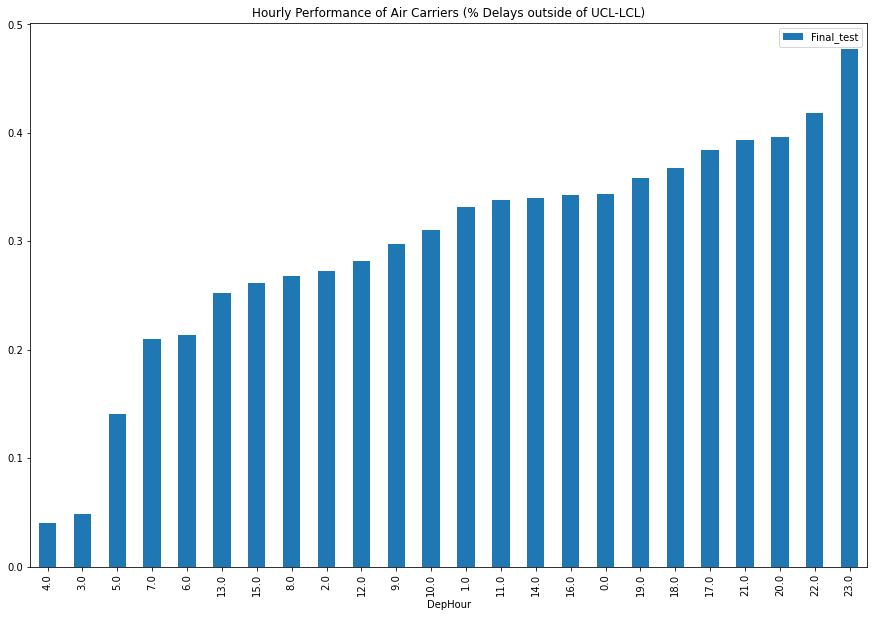

In [18]:
# Visualizing the best time of the day to fly
sample1_time.reset_index().plot(x='DepHour', y='Final_test', kind='bar', figsize=(15, 10), title='Hourly Performance of Air Carriers (% Delays outside of UCL-LCL)')

#### The Best Time of the Day to Fly
would be 0400 hours (4am), as it is the timing with the lowest percentage of variation from the control limits. The next best times would be 0300 hours (3AM), followed by 0500 hours (5AM)

### Best Day of the Week to fly

In [19]:
sample1 = uncancelled_df.groupby(['Date', 'DayOfWeek']).apply(lambda x: x.sample(n=1000, random_state=13, replace=True).mean()).reset_index(drop=True)
sample1_weekday = sample1.groupby('DayOfWeek').agg({'DepDelay': x_test, 'ArrDelay': x_test})
sample1_weekday['Final_test'] = (sample1_weekday['DepDelay'] + sample1_weekday['ArrDelay']) / 2
sample1_weekday = sample1_weekday.sort_values(by='Final_test', ascending=True)

print("The best day of the week with minimal delays to depart on is {}".format(week_dict[sample1_weekday.index[0]]))


/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/2899458252.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sample1 = uncancelled_df.groupby(['Date', 'DayOfWeek']).apply(lambda x: x.sample(n=1000, random_state=13, replace=True).mean()).reset_index(drop=True)


The best day of the week with minimal delays to depart on is Saturday


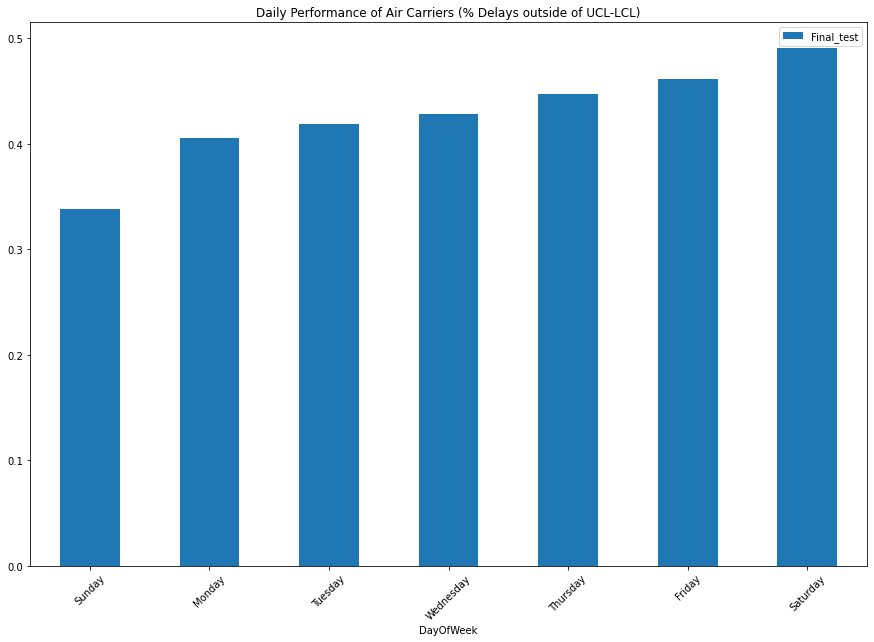

In [20]:
# Visualizing best day of the week to fly
ax_weekday = sample1_weekday.reset_index().plot(x='DayOfWeek', y='Final_test', kind='bar', figsize=(15, 10), title='Daily Performance of Air Carriers (% Delays outside of UCL-LCL)')
plt.xticks(range(7), [week_dict[i] for i in range(1, 8)], rotation=45)
plt.show()

#### The Best Day of the Week to Fly
would be Saturday, as it is the day with the lowest percentage of variation from the control limits. The next best times would be Monday, followed by Tuesday.

### Best Time of the Year to fly (Month)

In [21]:
sample1 = uncancelled_df.groupby(['Date']).apply(lambda x: x.sample(n=100, random_state=13, replace=True).mean()).reset_index(drop=True)
sample1_months = sample1.groupby('Month').agg({'DepDelay': x_test, 'ArrDelay': x_test})
sample1_months['Final_test'] = (sample1_months['DepDelay'] + sample1_months['ArrDelay']) / 2
sample1_months = sample1_months.sort_values(by='Final_test', ascending=True)

print("In order to minimise delays, the best time of the year to depart on is {}".format(month_dict[sample1_months.index[0]]))

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/734934200.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sample1 = uncancelled_df.groupby(['Date']).apply(lambda x: x.sample(n=100, random_state=13, replace=True).mean()).reset_index(drop=True)


In order to minimise delays, the best time of the year to depart on is January


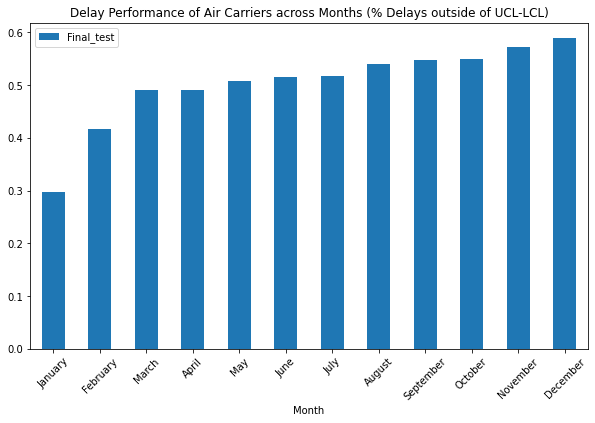

In [22]:
# Visualizing best time of year to fly (month)
ax_month = sample1_months.reset_index().plot(x='Month', y='Final_test', kind='bar', figsize=(10, 6), title='Delay Performance of Air Carriers across Months (% Delays outside of UCL-LCL)')
plt.xticks(range(12), [month_dict[i] for i in range(1, 13)], rotation=45)
plt.show()

#### The Best Time of the Year to Fly
would be January, as it is the month with the lowest percentage of variation from the control limits. The next best times would be February, followed by March.

# Q2. Do older planes suffer more delays?

***Variables required:***
- Related aircraft identifiers: tailnum, 
- Aircraft Age
- Delay-information: ArrDelay, DepDelay

In [23]:
planes = pd.read_csv('plane-data.csv')
planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5029 entries, 0 to 5028
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   tailnum        5029 non-null   object
 1   type           4480 non-null   object
 2   manufacturer   4480 non-null   object
 3   issue_date     4480 non-null   object
 4   model          4480 non-null   object
 5   status         4480 non-null   object
 6   aircraft_type  4480 non-null   object
 7   engine_type    4480 non-null   object
 8   year           4480 non-null   object
dtypes: object(9)
memory usage: 353.7+ KB


In [24]:
# convert the 'col1' column to integers, while 'None' types will be converted to NaN to be dropped
planes['year'] = pd.to_numeric(planes['year'], errors='coerce').astype('Int32')
# We will drop the rows with null values as they do not possess useful aircraft info for us, and are a small portion of the overall data size.
planes.dropna(axis=0, inplace=True) # Drop any rows containing NA values
planes.reset_index(drop=True, inplace=True)

planes.isna().sum()

tailnum          0
type             0
manufacturer     0
issue_date       0
model            0
status           0
aircraft_type    0
engine_type      0
year             0
dtype: int64

In [25]:
# By comparing, 'year' column seems to be more accurate of the plane's starting date instead of 'issue_date'
# Drop the 'issue_date column'
planes = planes.drop('issue_date', axis=1)
# Renaming 'year' column 'AircraftYear' 
planes = planes.rename(columns={"year": "AircraftYear",
                               "tailnum": "TailNum"})

In [26]:
# Duplicate a new dataframe from the main df containing essential columns.
flights_planes = merged_df[['Year', 'TailNum', 'DepDelay', 'ArrDelay']]

# Merge both CSVs with common column 'tailnum'
flights_planes = flights_planes.merge(planes, how='left', left_on='TailNum', right_on='TailNum')
flights_planes = flights_planes.dropna(axis=0).reset_index(drop=True)
flights_planes.isna().sum()

Year             0
TailNum          0
DepDelay         0
ArrDelay         0
type             0
manufacturer     0
model            0
status           0
aircraft_type    0
engine_type      0
AircraftYear     0
dtype: int64

#### Explore the range and spread of aircraft ages to better gauge an aircraft's newness/oldness.

We will use the following formula to calculate aircraft age: **Aircraft Age = Year of flight - Issue Year**

In [27]:
# Create new column 'Age' to store calculated age of aircraft
flights_planes['Age'] = flights_planes['Year'] - flights_planes['AircraftYear']

By calculating the difference between both year-based columns, some of the calculated aircraft ages are negative.
Upon further research, this might be due to some cases of older aircraft tail numbers being reused and reassigned to newer aircraft.
Source: https://aerocorner.com/blog/airplane-tail-numbers-explained/

For accurate analysis, we will only retain positive age values (Age>0).

In [28]:
flights_planes = flights_planes[flights_planes['Age'] >= 0]

# Check range of plane ages and sort ascendingly
print("Range of Aircraft Ages: \n", sorted(flights_planes['Age'].unique()))

Range of Aircraft Ages: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 2006, 2007]


Some flight records have impossible ages (eg. 2005/2006/2007), so we will drop any flights containing such records.

In [29]:
flights_planes = flights_planes[(flights_planes['Age'] < 200)] # Remove erroneously large plane ages
flights_planes.reset_index(drop=True, inplace=True)
# Re-check range of plane ages
print("Range of Aircraft Ages: \n", sorted(flights_planes['Age'].unique()))

Range of Aircraft Ages: 
 [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51]


#### Visualising proportion of flight delays by aircraft ages

In [30]:
flights_planes['Delayed'] = np.where((flights_planes['DepDelay']!=0) | (flights_planes['ArrDelay']!=0),1,0)

<AxesSubplot: xlabel='Age', ylabel='count'>

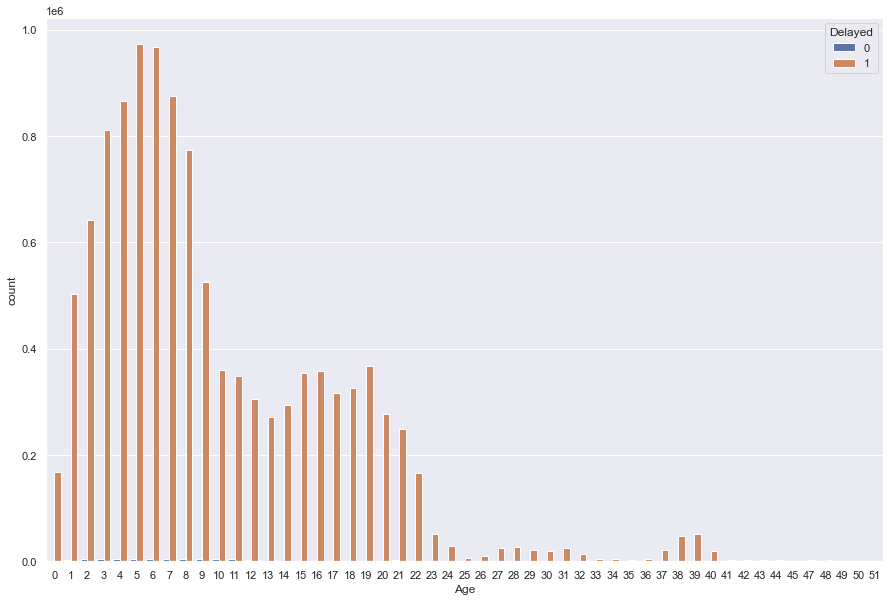

In [130]:
colours = ['#5F9E6E', '#CC8963']

sns.countplot(x = 'Age', hue = 'Delayed', data = flights_planes)

## Hypothesis Testing
Furthermore, we will apply the Chi-Square test to the claim 'Do older planes suffer more delays?' 

#### H0: Older planes suffer more delays. 
#### H1: Older planes do not suffer more delays.


In [32]:
chi , p = chisquare(np.array(flights_planes.groupby(['Age'])['Delayed'].sum()))
print("P value {:.9f}".format(p))
if p < 0.05:
  print("There is sufficient evidence to reject null hypothesis.")
else:
  print("There is insufficient evidence to reject null hypothesis.")

P value 0.000000000
There is sufficient evidence to reject null hypothesis.


### There is no evidence that older planes suffer more delays.
Chi-square testing has yielded a P value of arounds 0. Additionally, a visualisation of delayed flights by aircraft age reveals a heavy rightward-skew of the data, leaning towards  the newer planes. Overall, there is no significant evidence that older planes suffer more delays.

# Q3. How does the number of people flying between different locations change over time?

As this question deals with different locations, we will import the airport data csv.
Key variables of interest:
- Date: To track time values to identify the time period during which the flights change.
- Origin & Destination airport: We need to identify the airports from which people are flying to and from.
- Distance variables - to observe relationship between distance, timings and locations

First, lets observe the each year's flight volumes by month, air-time and route distance

#### Comparing monthly flight volumes between both years


(500000.0, 650000.0)

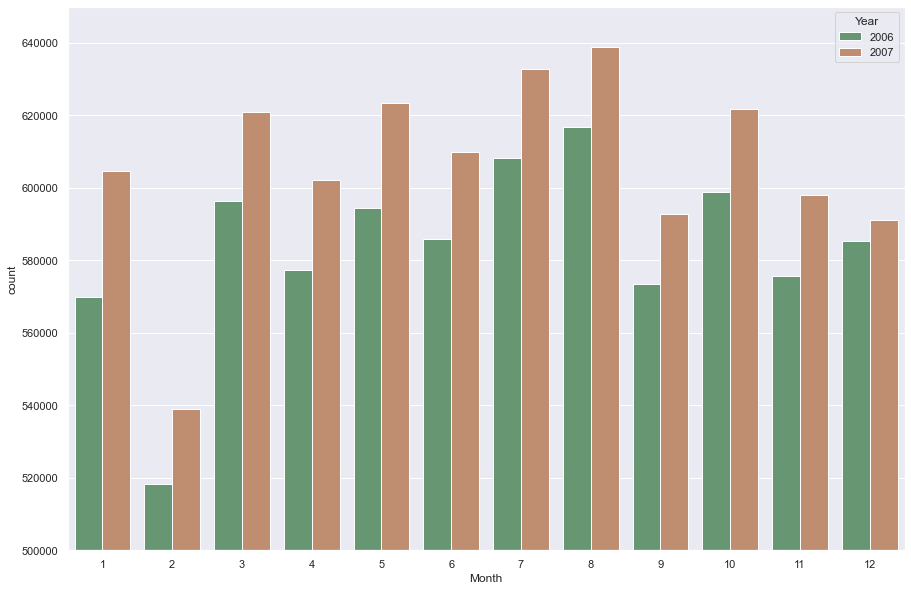

In [131]:
sns.countplot(x = 'Month', hue = 'Year', data = merged_df, palette = colours)
plt.ylim(500000, 650000)

The above figure depicts each year's monthly flight volumes. (For ease of viewing, the plot starts from 500,000 flights, since each month's minimum flight volume was above 500,000 flights.) <br>
2007 had the highest overall monthly number of flights than 2006 in every operating month.

#### Comparing yearly total airtime


(0.0, 500.0)

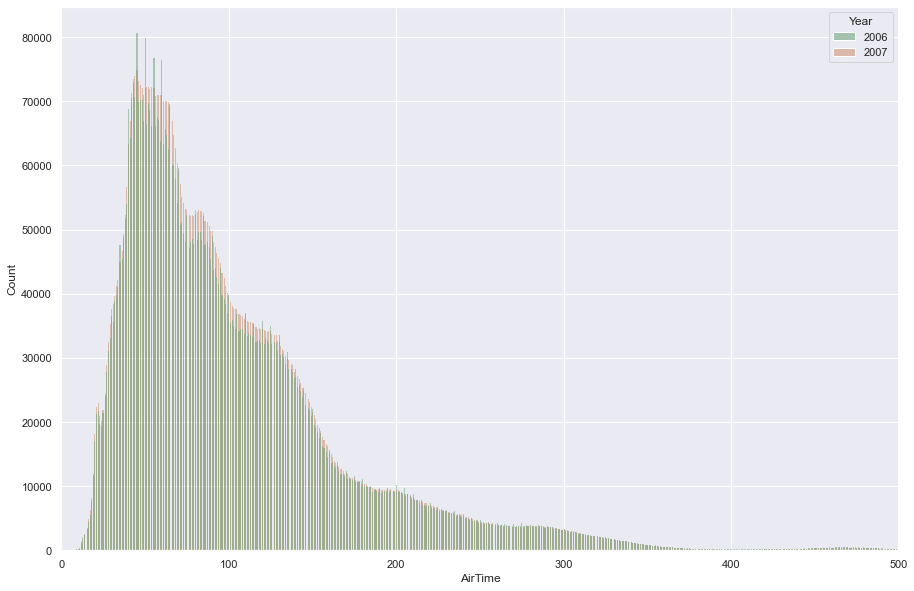

In [132]:
sns.histplot(x= 'AirTime', hue = 'Year', data = merged_df, palette = colours)
plt.xlim(0 , 500)

Most flights within the United States are relatively short-haul flights, with over half of all flights being under 3 hours (180 minutes).

#### Comparing yearly total flight distance 

(0.0, 3000.0)

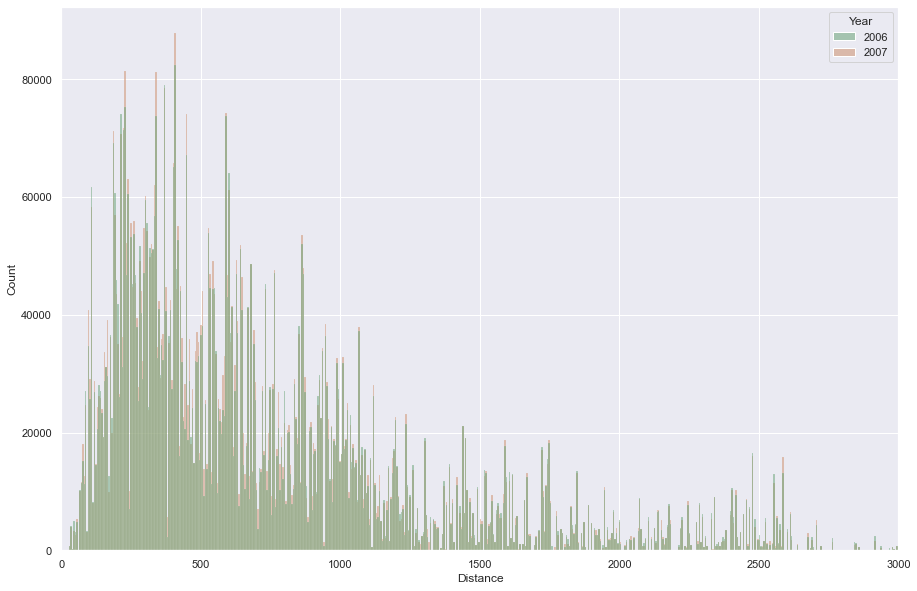

In [134]:
sns.histplot(x= 'Distance', hue = 'Year', data = merged_df, palette = colours)
plt.xlim(0,3000)

In line with the earlier airtime visualisation's findings, the majority of flights are short-haul flights under 1000miles, with the modal flight distance being under 500miles.

#### Observing route frequencies over the years

we will be joining the flight data with an external dataset containing US airport geographical and locational data to deep-dive into route frequencies.

In [33]:
airports = pd.read_csv('airports.csv')
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3376 entries, 0 to 3375
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   iata     3376 non-null   object 
 1   airport  3376 non-null   object 
 2   city     3364 non-null   object 
 3   state    3364 non-null   object 
 4   country  3376 non-null   object 
 5   lat      3376 non-null   float64
 6   long     3376 non-null   float64
dtypes: float64(2), object(5)
memory usage: 184.8+ KB


In [34]:
airports = airports.rename(columns={"iata": "IATA",
                               "lat": "latitude",
                                    "long": "longitude"})
airports # Check changes

IATA                    airport              city state country  \
0     00M                   Thigpen        Bay Springs    MS     USA   
1     00R       Livingston Municipal        Livingston    TX     USA   
2     00V                Meadow Lake  Colorado Springs    CO     USA   
3     01G               Perry-Warsaw             Perry    NY     USA   
4     01J           Hilliard Airpark          Hilliard    FL     USA   
...   ...                        ...               ...   ...     ...   
3371  ZEF            Elkin Municipal             Elkin    NC     USA   
3372  ZER  Schuylkill Cty/Joe Zerbey        Pottsville    PA     USA   
3373  ZPH      Zephyrhills Municipal       Zephyrhills    FL     USA   
3374  ZUN                 Black Rock              Zuni    NM     USA   
3375  ZZV       Zanesville Municipal        Zanesville    OH     USA   

       latitude   longitude  
0     31.953765  -89.234505  
1     30.685861  -95.017928  
2     38.945749 -104.569893  
3     42.741347  -78.052081  
4     30.688012  -81.905944  
...         ...         ...  
3371  36.280024  -80.786069  
3372  40.706449  -76.373147  
3373  28.228065  -82.155916  
3374  35.083227 -108.791777  
3375  39.944458  -81.892105  

[3376 rows x 7 columns]

#### Route Volumes by Year

In [38]:
# Create 'Route' column
merged_df['Route'] = merged_df['Origin'] + '-' + merged_df['Dest']

new_order = ['Date', 'Year', 'Month', 'Day', 'DayOfWeek', 'DepTime', 'DepHour',
       'CRSDepTime', 'ArrTime', 'CRSArrTime', 'FlightNum', 'TailNum',
       'ActualElapsedTime', 'CRSElapsedTime', 'AirTime', 'ArrDelay',
       'DepDelay', 'Route', 'Origin', 'Dest', 'Distance', 'Cancelled', 'CarrierDelay',
       'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay',
       'SumOfDelays'] 
merged_df = merged_df.reindex(columns=new_order).reset_index(drop=True) 

# Group by Year, Origin, Dest, Distance, and Route
route_data = merged_df.groupby(['Year', 'Origin', 'Dest', 'Distance', 'Route']).size().reset_index(name='Count')

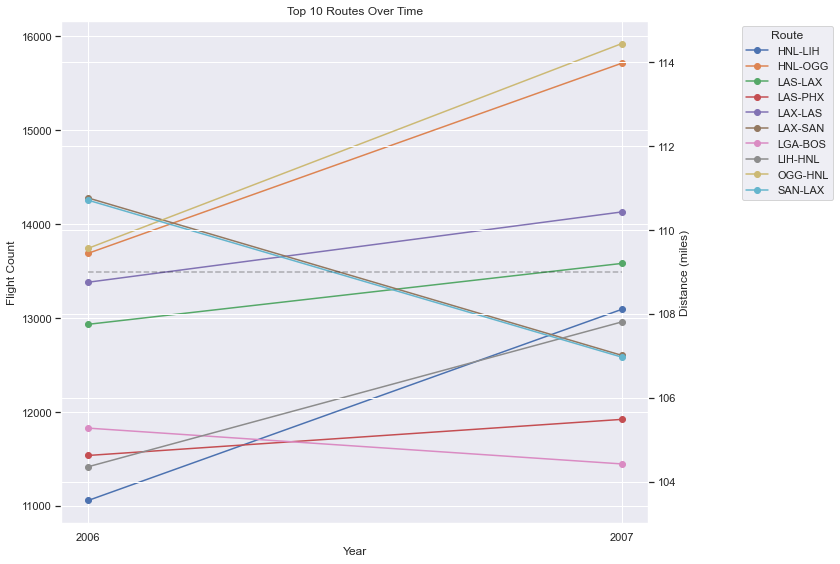

In [39]:
# Filter for top N routes across all years
N = 10
top_routes = route_data.groupby('Route')['Count'].sum().nlargest(N).reset_index()

# Filter the route_data for the top N routes
top_routes_data = route_data[route_data['Route'].isin(top_routes['Route'])]

fig, ax = plt.subplots(figsize=(12, 8))

for route in top_routes_data['Route'].unique():
    route_data = top_routes_data[top_routes_data['Route'] == route]
    ax.plot(route_data['Year'].astype(str), route_data['Count'], label=route, marker='o')

ax.set_xlabel('Year')
ax.set_ylabel('Flight Count')
ax.set_title(f'Top {N} Routes Over Time')

# Add a second y-axis for distance
ax2 = ax.twinx()
ax2.set_ylabel('Distance (miles)')
ax2.plot(route_data['Year'].astype(str), route_data['Distance'], 'k--', alpha=0.3)

# Move the legend to the side outside the graph
ax.legend(title='Route', bbox_to_anchor=(1.15, 1), loc='upper left')

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

### Geo-spatial analysis of flight volumes across distances using Folium library

##### Pre-processing the data to produce a map in Folium

In [40]:
# 1. Preparing variables relevant to the question.
airport_coord = airports[['IATA', 'latitude', 'longitude']]
total_routes = merged_df.groupby(['Route', 'Origin', 'Dest']).size().reset_index(name='Count')
print(f"There are {len(total_routes)} unique flight routes.")

#2. Sort routes by count and add 'Route' name
total_routes = total_routes.sort_values('Count', ascending=False)
total_routes['Route'] = total_routes['Origin'] + '-' + total_routes['Dest']
cols = ['Route', 'Origin', 'Dest', 'Count']
total_routes = total_routes[cols]
total_routes.reset_index(drop=True, inplace=True)

# 3. Merge top route info with their geo-coordinates
total_routes_data = pd.merge(total_routes, airport_coord, left_on='Origin', right_on='IATA')
total_routes_data = pd.merge(total_routes_data, airport_coord, left_on='Dest', right_on='IATA', suffixes=('_Origin', '_Dest'))
# 4. Drop the resultant 'IATA-' columns as they are now redundant
total_routes_data = total_routes_data.drop(['IATA_Origin', 'IATA_Dest'], axis=1)

total_routes_data # Display dataframe containing flight dates, route locations and their corresponding coordinates.

There are 5345 unique flight routes.


Route Origin Dest  Count  latitude_Origin  longitude_Origin  \
0     OGG-HNL    OGG  HNL  29665        20.898650       -156.430458   
1     LAX-HNL    LAX  HNL  10736        33.942536       -118.408074   
2     SAN-HNL    SAN  HNL    783        32.733556       -117.189657   
3     LAS-HNL    LAS  HNL   1754        36.080361       -115.152333   
4     LIH-HNL    LIH  HNL  24377        21.975983       -159.338958   
...       ...    ...  ...    ...              ...               ...   
5340  JNU-PSG    JNU  PSG    691        58.354962       -134.576276   
5341  WRG-PSG    WRG  PSG    692        56.484326       -132.369824   
5342  JNU-YAK    JNU  YAK    689        58.354962       -134.576276   
5343  CDV-YAK    CDV  YAK    705        60.491834       -145.477650   
5344  JNU-GST    JNU  GST    169        58.354962       -134.576276   

      latitude_Dest  longitude_Dest  
0         21.318691     -157.922407  
1         21.318691     -157.922407  
2         21.318691     -157.922407  
3         21.318691     -157.922407  
4         21.318691     -157.922407  
...             ...             ...  
5340      56.801652     -132.945278  
5341      56.801652     -132.945278  
5342      59.503361     -139.660226  
5343      59.503361     -139.660226  
5344      58.424381     -135.707381  

[5345 rows x 8 columns]

In [41]:
# The range of values in 'count' is too large, so we'll scale it with MinMaxScaler.
scaler = MinMaxScaler(feature_range=(0, 1))
total_routes_data['norm_count'] = scaler.fit_transform(total_routes_data[['Count']])

# Create map
map1 = folium.Map(location=[48.0902, -105.7129], zoom_start=3)
# Create function to add a line to the map for each route
def add_route(row):
    origin = (row['latitude_Origin'], row['longitude_Origin'])
    dest = (row['latitude_Dest'], row['longitude_Dest'])
    count = row['norm_count']
    folium.PolyLine([origin, dest], weight=count*3, color='purple', opacity=0.1).add_to(map1)
    
# Add each route to the map
total_routes_data.apply(add_route, axis=1)
# Display the map
map1


# Q4. Can you detect cascading failures as delays in one airport create delays in others?

Imagine if you face a flight delay of 1 hour at New York's La Guardia Airport (LGA) and subsequently arrive late at Los Angeles International Airport (LAX). It makes sense that the same plane would also face a delay for its next scheduled flight out of LAX, so on and so forth for the plane's scheduled flights.

We posit that late flight arrivals will cause a cascading ripple effect on time, contributing to late departures at the destination airport.

Lets formulate a ratio by summing all the delayed flights at an origin, then divide it by the total flight volume at the same location and within the same time frame - this gives us the ability to track a cascading effect, as an increased ratio may suggest a downstream impact on airports. <br>Hence, for the time **t**: **Delay Ratio = SumOfDelays(t) / total flights(t)**
- All types of aircraft delays (incl. weather and airspace delays) are factored into the delay ratio as they influence aircraft departure times. Arrival delay ('ArrDelay) is excluded as it is the eventual by-product of the other delay-factors.

To better explore the cascading effects of flight delays between locations, we will focus on a major airport and its affected flights to triangulate its any cascading impacts on surrounding nodes/airports in the aviation network.

##### Top 5 delayed flights

In [42]:
# Aggregate all delay-types together into an overall 'SumOfDelays'
merged_df['SumOfDelays'] = merged_df['DepDelay'] + merged_df['CarrierDelay'] + merged_df['WeatherDelay'] + merged_df['NASDelay'] + merged_df['SecurityDelay'] + merged_df['LateAircraftDelay']

# Largest sum of delays duration for a flight
longest_delay = merged_df['SumOfDelays'].max()
print(f"The largest sum of delays on a single flight is {longest_delay}minutes ({longest_delay/60} hrs).")

# Create a list-format for the columns that we'll be lifting from the main dataframe.
delay_format = ['Date', 'Origin', 'Dest', 'SumOfDelays']

# Separate the flight(s) with the greatest sum of delays.
largest_delays_df = merged_df[delay_format].nlargest(n=5, columns='SumOfDelays')
largest_delays_df

The largest sum of delays on a single flight is 5199.0minutes (86.65 hrs).


Date Origin Dest  SumOfDelays
12916542  2007-10-03    PBI  DTW       5199.0
14127489  2007-12-01    ALO  MSP       3898.0
12915409  2007-10-02    HNL  MSP       3679.0
5663791   2006-10-12    BUF  DTW       3531.0
12937045  2007-10-28    FWA  DTW       3451.0

##### Identifying the airport with the most outbound delays

In [43]:
# Store a list of unique destination airports
destinations = list(merged_df['Dest'].unique())

# Create a dictionary of delayed flights grouped by their destination airports
  # Loop through destination list, group no. of flights with positive sum of delays, by their unique destination 
delayed_destinations = {destination: merged_df.loc[(merged_df['Dest'] == destination) & (merged_df['SumOfDelays'] > 0), 'Dest'].count()
                for destination in destinations}

# Separating the airport with the most delays
most_delayed_dest_airport = pd.Series(delayed_destinations).idxmax()
largest_count = delayed_destinations[most_delayed_dest_airport]

print(f"The airport with the highest number of incoming flight delays is {most_delayed_dest_airport} ({largest_count} delays).")

The airport with the highest number of incoming flight delays is ATL (346329 delays).


The airport with the highest number of incoming delays is **Hartsfield-Jackson Atlanta International Airport**.

Hence, we will focus on this airport due to its extent of operations and observe its outgoing flight delays, along with any impacts on surrounding airports.

In [44]:
# Store a list of unique origin airports
origins = list(merged_df['Origin'].unique())

# Create a dictionary of delayed flights grouped by their origin airports
  # Loop through destination list, group no. of flights with positive sum of delays, by their unique destination 
delayed_origins = {origin: merged_df.loc[(merged_df['Origin'] == origin) & (merged_df['SumOfDelays'] > 0), 'Origin'].count()
                for origin in origins}

# Separating the airport with the most delays
most_delayed_orig_airport = pd.Series(delayed_origins).idxmax()
largest_count = delayed_origins[most_delayed_orig_airport]

print(f"The airport with the highest number of outgoing flight delays is {most_delayed_orig_airport} ({largest_count} delays).")


The airport with the highest number of outgoing flight delays is ATL (425259 delays).


Once again, **Hartsfield-Jackson Atlanta International Airport** is the culprit for having the most delayed departures as an origin airport. <br>

With the number of outgoing flight delays surpassing the incoming flight delays, this could indicate a spillover impact of delayed flights touching down later, delaying the airport's flight operations schedule. This may subsequently delay other aircraft departures as backlogs form to depart from the airport - Hence, a possible cascading delay.

### Analysing airport delay performance over time (Moving-Average)

In [ ]:
# Create list of top 3 origin airports by flights to visualise
top_origins = merged_df['Origin'].value_counts().head(3).index.tolist()
print(f"Top {len(top_origins)} origin airport(s) by flight volume: \n{top_origins}.")
# Get a list of unique flight dates
dates = merged_df['Date'].unique().tolist()

Top 3 origin airport(s) by flight volume: 
['ATL', 'ORD', 'DFW'].


##### Delay ratio of origin airports

In [47]:
def calculate_origin_delay_ratio(origin, dates, merged_df):
    delay_ratios = {'Origin': [], 'Date': [], 'DelayRatio': [], 'FlightCount': []}

    for date in dates:
        unique_origin = merged_df[(merged_df['Origin'] == origin) & (merged_df['Date'] == date)]
        delay_count = unique_origin[unique_origin['SumOfDelays'] > 0]['SumOfDelays'].count()
        flight_count = unique_origin['SumOfDelays'].count()
        delay_ratio = delay_count / flight_count if flight_count > 0 else 0
        delay_ratios['Origin'].append(origin)
        delay_ratios['Date'].append(date)
        delay_ratios['DelayRatio'].append(delay_ratio)
        delay_ratios['FlightCount'].append(flight_count)

    return pd.DataFrame(delay_ratios)

##### Visualising airport delay performance 

In [48]:
def plot_flight_count_and_delay_ratios_moving_avg(origin, merged_df, window=7):
    fig, ax = plt.subplots(figsize=(30, 15))

    flight_counts = merged_df[merged_df['Origin'] == origin].groupby('Date').size()
    max_flight_count = flight_counts.max()
    scaled_flight_counts = flight_counts / max_flight_count
    moving_avg_scaled_flight_counts = scaled_flight_counts.rolling(window=window, center=True).mean()

    delay_ratios = calculate_origin_delay_ratio(origin, dates, merged_df)
    delay_ratios['MovingAverage'] = delay_ratios['DelayRatio'].rolling(window=window, center=True).mean()

    ax.plot(flight_counts.index, moving_avg_scaled_flight_counts, label=f"{origin} Flight Count (Scaled)", color='green')
    ax.scatter(delay_ratios['Date'], delay_ratios['MovingAverage'], label=f"{origin} Delay Ratio", color='blue')

    ax.set_xlabel('Date', fontsize=18)
    ax.set_ylabel('Scaled Values', fontsize=18)
    ax.set_ylim(0, 1)
    ax.xaxis.set_major_locator(mdates.DayLocator(interval=7))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))

    start_date = pd.to_datetime(delay_ratios['Date'].min()).date()
    end_date = pd.to_datetime(delay_ratios['Date'].max()).date()
    num_ticks = 20
    date_range = pd.date_range(start_date, end_date, num_ticks)
    xticks = [mdates.date2num(datetime.combine(d.date(), datetime.min.time())) for d in date_range]

    ax.set_xticks(xticks)
    ax.set_xticklabels([d.date().strftime('%m/%d/%Y') for d in date_range], rotation=45, ha='right', fontsize=15)

    ax.set_title("Flight Count (Scaled) and Delay Ratio (Moving Average)")
    ax.legend(loc='upper left', fontsize=18)
    plt.title(f"{origin} - Airport Delay Ratio (Moving Average)", fontsize=25)
    plt.savefig(origin + ' - DelayRatios_full.png', transparent=True)
    plt.show()

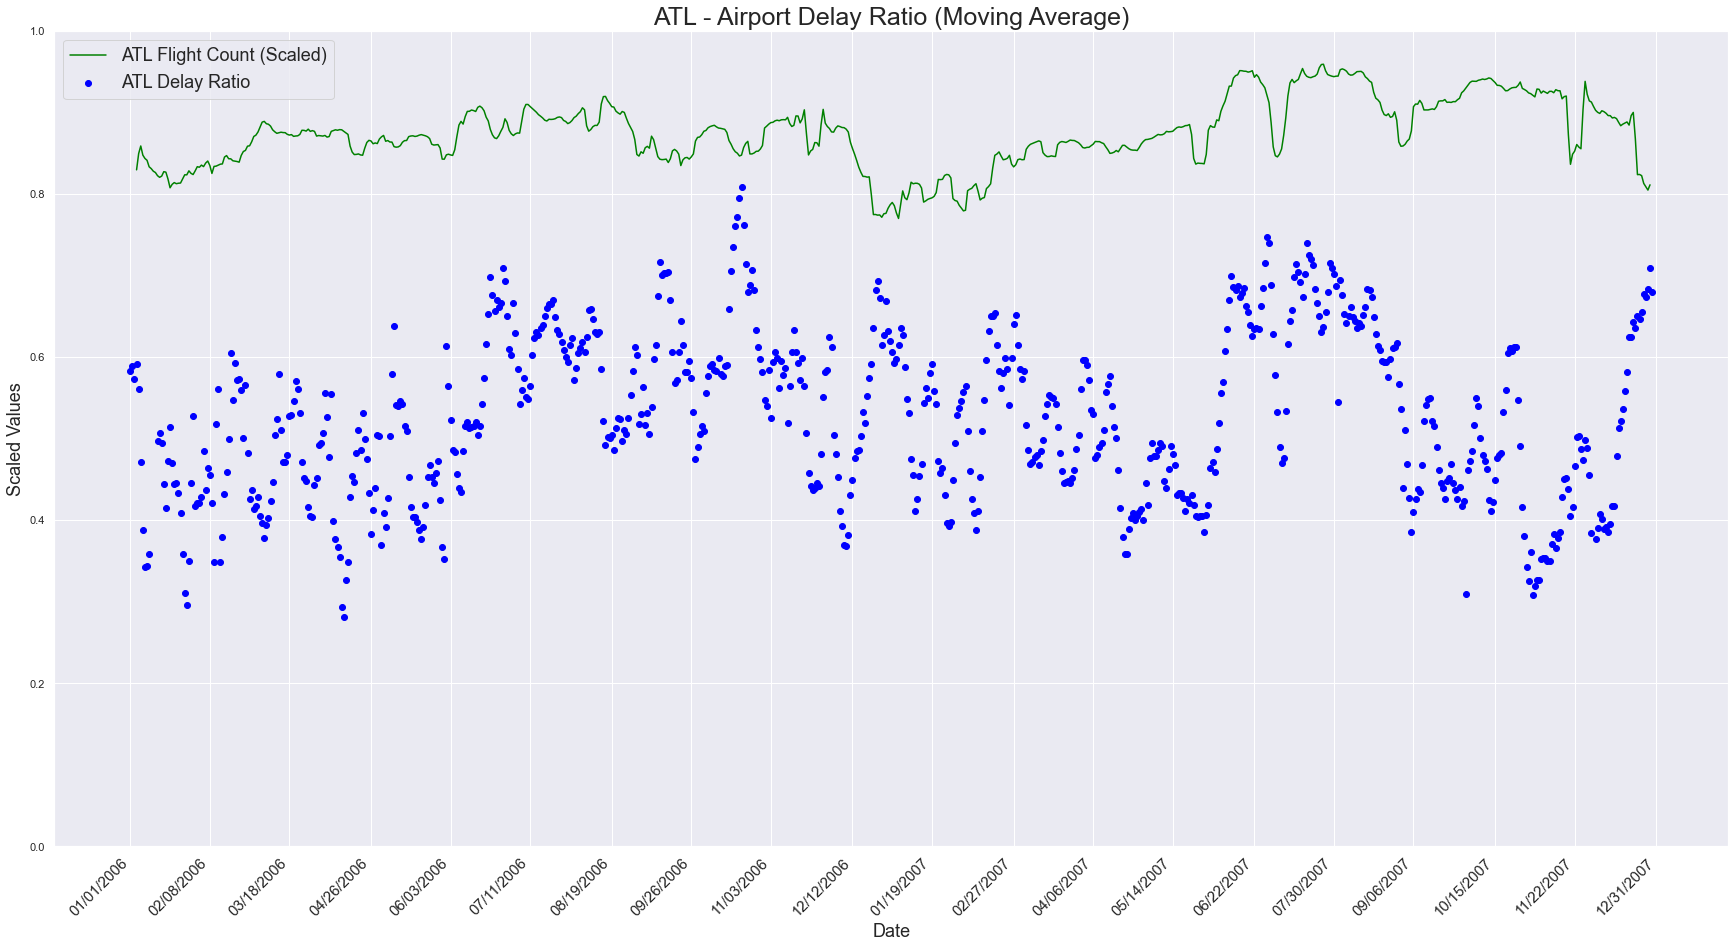

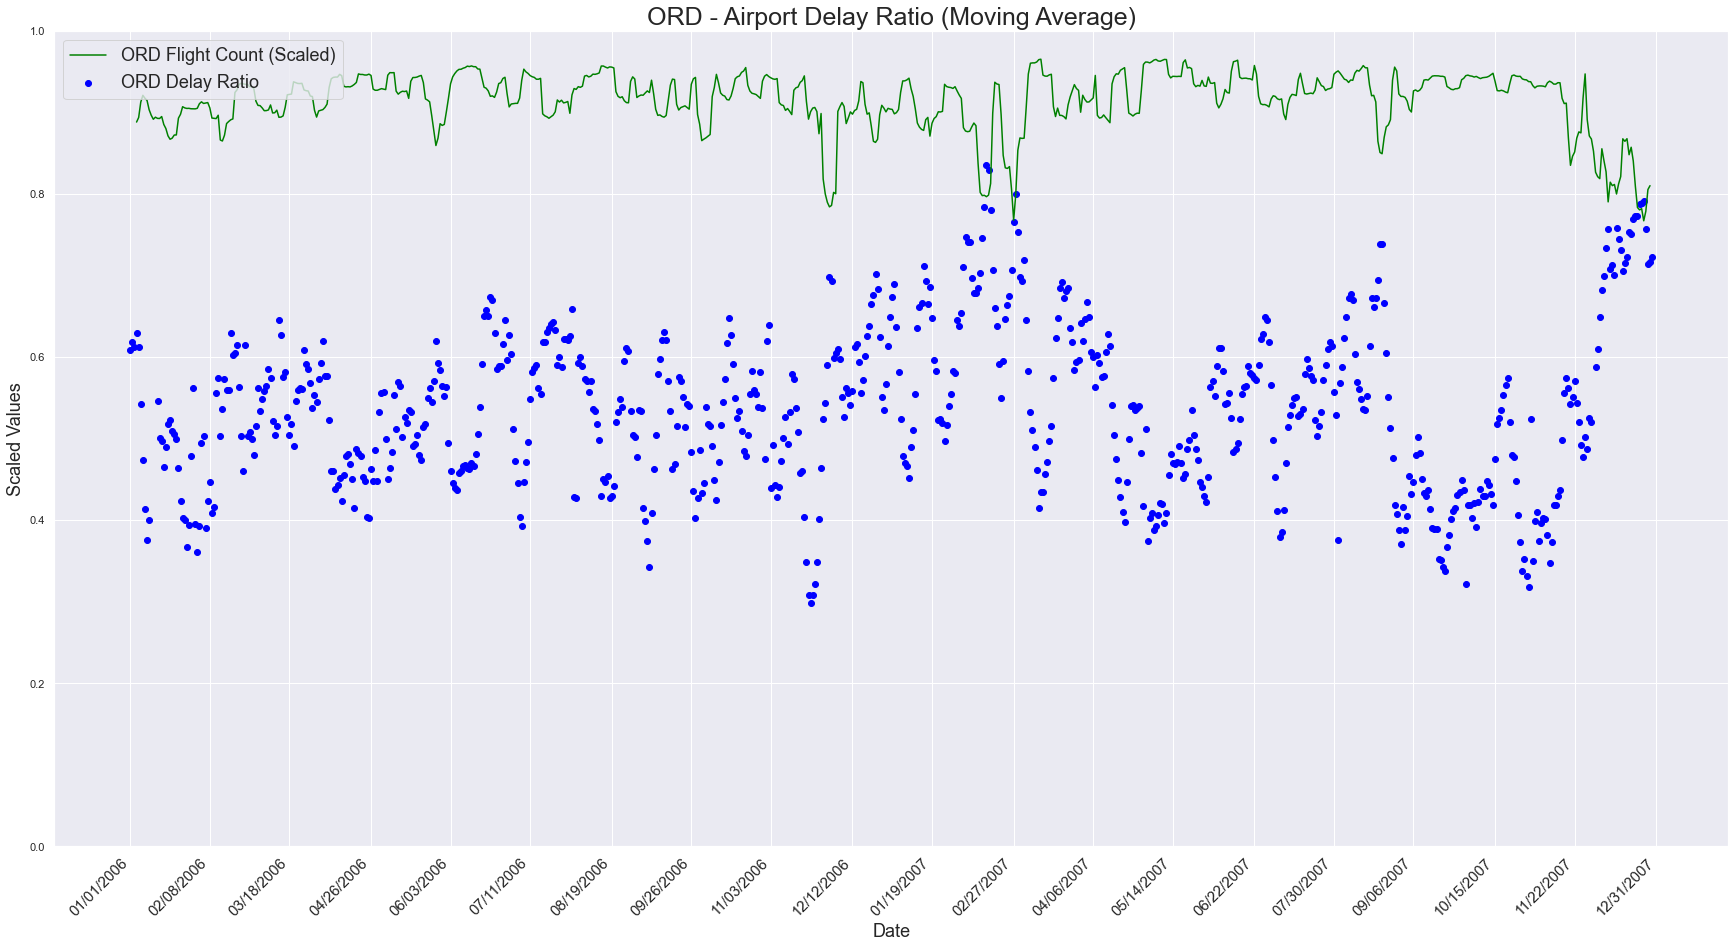

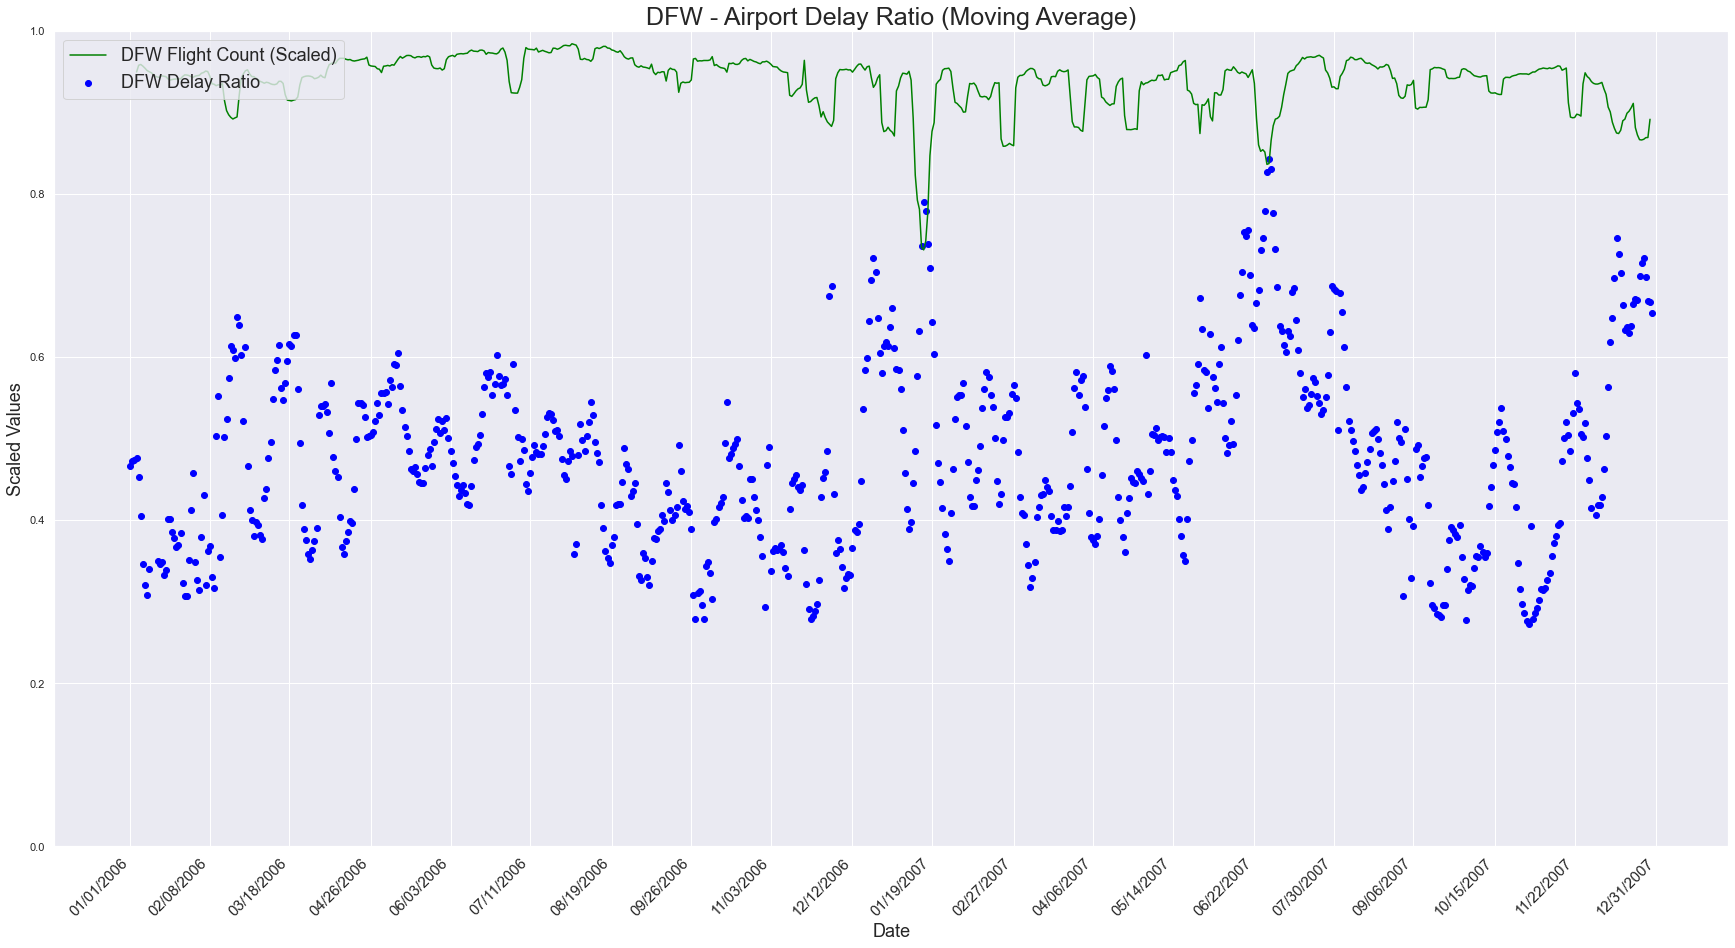

In [49]:
# Plot the flight count (scaled) and delay ratios (moving average) on the same graph
for origin in top_origins:
    plot_flight_count_and_delay_ratios_moving_avg(origin, merged_df, window=7)

# Building a Regression Model
Variable types of interest: 
- Target variable: 'ArrDelay' (Flights operating more than 15mins after scheduled CRS times are counted as delayed flights)
- Datetime variables: 'Month', 'Day','DayOfWeek'
- Locational variables: 'Origin', 'Dest'
- Scheduled departure time: 'CRSDepTime'

In [51]:
# Dropping 'Route' since we have 'Origin' and 'Dest', and we drop 'Cancelled' since are focus is on uncancelled flights
merged_df.drop(['Route', 'Cancelled'], axis=1, inplace=True)

##### Check variable relationships via Correlation Matrix

/var/folders/g8/5qv_fc053mn_8790gqh1gklm0000gn/T/ipykernel_11663/439478625.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = merged_df.corr() # Correlation matrix


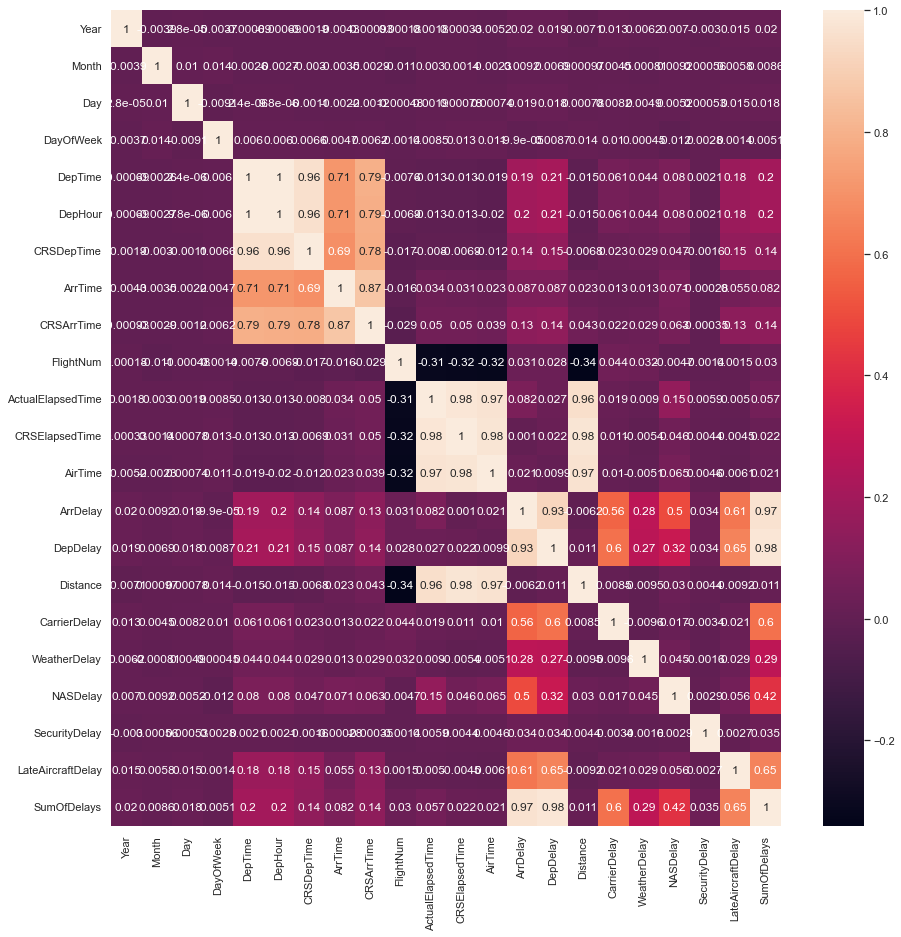

In [52]:
corr_matrix = merged_df.corr() # Correlation matrix
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, ax=ax)

plt.show()

We will take arrival delay ('ArrDelay') as the target variable to predict flight delays.

In [114]:
# Slice the data and return a new Data Frame
segment = merged_df.sample(n=20000, random_state=13)

##### Preprocessing
Before building the model, it's essential to preprocess the data. This includes handling missing values, encoding categorical variables, and scaling the features. Data preprocessing is crucial because it ensures that the data is clean and compatible with the model, improving its overall performance.

In [115]:
# Define categorical and numerical columns
categorical_columns = ['Origin', 'Dest', 'Month','DayOfWeek', 'DepHour', 'TailNum']
numerical_columns = ['Distance', 'CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay']

# Split data into features and target variable
X = segment[categorical_columns + numerical_columns]
y = segment['ArrDelay']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=13)

##### Feature encoding and scaling 
Encoding categorical variables is necessary because SVR can only handle numerical inputs. We will use one-hot encoding to transform categorical variables into a binary format. Additionally, we will scale the numerical features to bring them to the same scale, which can help the model converge faster and improve its performance.

In [116]:
# Create a column transformer to handle both categorical and numerical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

##### Model: Predicting the extent of arrival delays with Support Vector Regression (SVR)

We will be predicting the target variable ArrDelay using SVR.

SVR works by mapping inputted data into higher-dimensional feature spaces, where data points in a continuous space can be separated or fitted clearly by hyperplanes that maximise the margin between the hyperplane and the closest data points. We chose the Radial Basis Function (RBF) kernel since its method of measuring similarity between pairs of data points in a feature space works well with complex, non-linear variables.

**Suitability** <br>
SVR model has been widely researched to be well-suited to complex prediction tasks, such as flight delay prediction. SVR is comparatively robust and flexible, being resilient against unpredictability and outliers. Additionally, it can also handle both linear and non-linear relationships between the features and target variable (Drucker et al., 1997), allowing it to adapt to complex flight data. Lastly, SVR can efficiently handle higher-dimensional data (Cristianini & Shawe-Taylor, 2000) such as airline data, which involves numerous features.

**Evaluation Metrics**
- **MAE**: Represents the average absolute difference between the predicted and actual arrival delay times. A lower MAE value is generally better, indicating that the model is making smaller errors in its predictions. For example, an MAE of 4.5 means that the model's predictions are on average, 4.5 minutes away from the actual timings. <br>
- **MSE**: Similar to MAE, MSE calculates the average of the squared differences between the predicted and actual values. Like MAE, the lower the MSE, the better the model's performance.
- **R2**: Measures the proportion of the total variation in the data that is explained by the model. The value ranges from 0 to 1, with higher values indicating a better fit. An R-squared of 0.94 means that the model explains 94% of the variation in the arrival delay times. 

In [ ]:
# Create an instance of the SelectKBest method
k_best = SelectKBest(score_func=f_regression, k=10)

# Create a pipeline with the preprocessor, feature selection, and the SVR model (kernel = 'rbf')
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('k_best', k_best),
    ('regressor', SVR())
])

In [117]:
# Train the model
svr_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Distance', 'CarrierDelay',
                                                   'WeatherDelay', 'NASDelay',
                                                   'SecurityDelay',
                                                   'LateAircraftDelay']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['Origin', 'Dest', 'Month',
                                                   'DayOfWeek', 'DepHour',
                                                   'TailNum'])])),
                ('k_best',
                 SelectKBest(score_func=<function f_regression at 0x1456e4160>)),
                ('regressor', SVR())])

In [118]:
# Evaluate the baseline performance
y_pred = svr_pipeline.predict(X_test)
mae_baseline = mean_absolute_error(y_test, y_pred)
mse_baseline = mean_squared_error(y_test, y_pred)
r2_baseline = r2_score(y_test, y_pred)
print(f"Baseline Mean Absolute Error (MAE): {mae_baseline:.2f}")

Baseline Mean Absolute Error (MAE): 7.71


The model's initial performance before further tweaks shows an MAE of 7.71, meaning that the model's arrival delay predictions average 7 minutes and 42 seconds away from actual timings.

In [119]:
# Perform hyperparameter tuning to improve
param_grid = {
    'regressor__C': [0.1, 1, 10],
    'regressor__kernel': ['linear', 'rbf'],
    'regressor__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svr_pipeline, param_grid, scoring='neg_mean_absolute_error', cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['Distance',
                                                                          'CarrierDelay',
                                                                          'WeatherDelay',
                                                                          'NASDelay',
                                                                          'SecurityDelay',
                                                                          'LateAircraftDelay']),
                                                                        ('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['Origin',
                                                                          'Dest',
                                                                          'Month',
                                                                          'DayOfWeek',
                                                                          'DepHour',
                                                                          'TailNum'])])),
                                       ('k_best',
                                        SelectKBest(score_func=<function f_regression at 0x1456e4160>)),
                                       ('regressor', SVR())]),
             n_jobs=-1,
             param_grid={'regressor__C': [0.1, 1, 10],
                         'regressor__gamma': ['scale', 'auto'],
                         'regressor__kernel': ['linear', 'rbf']},
             scoring='neg_mean_absolute_error', verbose=2)

In [120]:
# Train the model again using the best hyperparameters found in hyperparameter tuning
best_params = grid_search.best_params_
print(f"Best hyperparameters: {best_params}")

best_svr_pipeline = grid_search.best_estimator_

Best hyperparameters: {'regressor__C': 0.1, 'regressor__gamma': 'scale', 'regressor__kernel': 'linear'}


In [121]:
# Evaluate the performance of the model with the updated feature set and optimal hyperparameters
y_pred = best_svr_pipeline.predict(X_test)
mae_optimized = mean_absolute_error(y_test, y_pred)
print(f"Optimized Mean Absolute Error: {mae_optimized:.2f}")

Optimized Mean Absolute Error: 6.52


In [122]:
# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [123]:
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2): {r2:.2f}")

Mean Absolute Error (MAE): 6.52
Mean Squared Error (MSE): 82.97
R-squared (R2): 0.94


#### Model Evaluation

- **MAE: 6.52** The model's predictions are on average, 6.52 minutes away from the actual timings. <br>
- **MSE:** Average of squared differences between predicted and actual values dropped further highlighting improved model fit.
- **R2:** Our model explains 94% of the variation in the arrival delay times. 

The SVR model has demonstrated its potential for predicting flight delays effectively, as evidenced by the strong evaluation metrics on the validation set:

Despite the final model's results, here are some aspects and areas for improvement for our approach:

1. **Limited Training Size:** Due to the time-complexity of SVR models, they are may not be suited for large datasets like ours as they require long training times. Hence, our model was only trained on a limited subset of the data.
2. **Data Sampling:** Given the above training size constraints of SVR, the quality of samples is paramount - Perhaps stratified sampling may yield an overall better representation of the data as opposed to our random sampling approach.
3. **Feature Engineering:** Investigate additional features that could be relevant to flight delays, such as aircraft age, severity of airport congestion or seasonal factors, and incorporate them into the model.
4. **Time Series Split:** Time series split ensures that train datasets are older datapoints occuring earlier than the test data, which is more accurate since we can't train train on “future” data. Subsequently, this will also allow us to detect and rectify possible data or concept drift that our model may encounter in a future model-deployment phase.
4. **In-depth Model Selection:** We'll need to experiment with other machine learning models, such as ensemble methods, deep learning, or time series models to compare their performance with the SVR model and potentially improve prediction accuracy.
5. **Real-time Integration:** Integrate the model into either a flight tracker's database or an airline's operational systems to enable real-time flight delay predictions, which can be used for proactive decision-making.
6. **Continuous Improvement:** Regularly update the model with new data to ensure its accuracy and relevance as flight operations, regulations, and environmental factors evolve.
7. **Model Interpretability:** Explore ways to improve model interpretability to better understand the relationships between features and flight delays, enabling airlines to focus on addressing the root causes of delays.